This notebook revisits the analysis of Andrei, Mann, and Moyen (JFE 2019). 

There are two companion notebooks to this one: **AMM2019 - Archived data.ipynb** and **AMM2019 - FRED API data.ipynb** follow as closely as possible the approach in our original paper, which was in turn based on Hall (2001). 

This notebook removes many of those steps to simplify the procedure and highlight the patterns in the data that are intuitively important. In particular:

1. We do not attempt to adjust the book value of debt closer to market value of debt by accounting for changes in yields, as Hall did;
2. We do not adjust for inflation, which affects both the numerator and denominator of Q and the investment rate;
3. We use the same capital stock in the denominator of both investment and Q.

The biggest difference this makes is in the *level* of Q, and this in turn is mainly driven by item #1 above, the different approach to the valuation of debt. The *fluctuations* in Q arounds its average, which are implicitly the focus of most empirical analysis, are almost indistinguishible from what we obtain in the other notebooks. This makes sense because those fluctuations are mainly driven by equity values.

These figures are also closer in spirit to investment-Q analysis using Compustat data, where it is typical to calculate enterprise value using the book value of debt, without attempting to adjust this to market value as Hall does.

# Import packages

In [1]:
import fredapi
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
from dotenv import load_dotenv
load_dotenv();

# Download data from FRED

Import FRED API key and initiate session.

If you run this code on your own machine, substitute your own API key string in the first line.

In [2]:
Fred_session = fredapi.Fred()

Set beginning and end dates to use in data downloads.

In [3]:
first_obs = '1951-01-01'
last_obs = '2022-12-31'

BEA: Aggregate annual current-cost net-stock of private nonresidential fixed assets, and aggregate quarterly private nonresidential fixed investment (seasonally adjusted at annual rate) reported in NIPA tables.

- The latter figure is reported in billions in the raw data.

In [4]:
PNFI        = 1e3*Fred_session.get_series('PNFI', observation_start = first_obs, observation_end = last_obs)
net_capital = Fred_session.get_series('K1NTOTL1ES000', observation_start = first_obs, observation_end = last_obs)

Flow of funds: Financial value of corporate business

- The equity series is reported in millions, the other three in billions.

In [5]:
Equity      = Fred_session.get_series('NCBEILQ027S', observation_start = first_obs, observation_end = last_obs)
Liabilities = 1e3*Fred_session.get_series('TLBSNNCB', observation_start = first_obs, observation_end = last_obs)
FinAssets   = 1e3*Fred_session.get_series('TFAABSNNCB', observation_start = first_obs, observation_end = last_obs)
Inventories = 1e3*Fred_session.get_series('A373RC1Q027SBEA', observation_start = first_obs, observation_end = last_obs)

Reset all monthly datetime indexes to the correct frequency:

In [6]:
# Quarterly:
Equity      = Equity.set_axis(Equity.index.to_period('Q'))
Liabilities = Liabilities.set_axis(Liabilities.index.to_period('Q'))
FinAssets   = FinAssets.set_axis(FinAssets.index.to_period('Q'))
Inventories = Inventories.set_axis(Inventories.index.to_period('Q'))
PNFI        = PNFI.set_axis(PNFI.index.to_period('Q'))
# Annual:
net_capital = net_capital.set_axis(net_capital.index.to_period('Y'))

# Process data to construct investment rate and Tobin's Q

Calculate aggregate enterprise value of nonfinancial corporate business (the numerator of Tobin's Q).

Interpolate net capital, observed only in the last quarter of the year, linearly to the other three quarters of each year. 

In [7]:
net_capital_smooth = net_capital.resample('Q').interpolate().shift(3)

Calculate investment rate and Tobin's Q.

- Investment rate is investment during a quarter divided by stock of capital from the end of last quarter.
- Tobin's Q is enterprise value at the end of a quarter divided by capital stock at the end of the quarter.
- Due to this timing, in our analysis we compare the investment rate for a given quarter with *lagged* Tobin's Q.

In [8]:
EnterpriseValue = Equity + Liabilities - FinAssets - Inventories
Q = EnterpriseValue / net_capital_smooth
ik = PNFI / net_capital_smooth.shift()

## Visualizations and regressions of the investment-Q relationship.

Investment and lagged Q in levels:

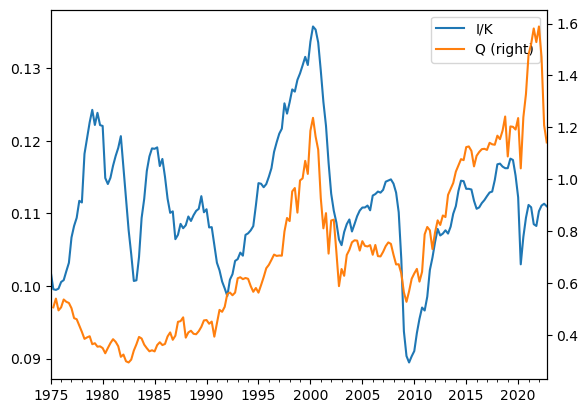

In [9]:
ik['1975Q1':].plot(legend=True,label="I/K");
Q['1975Q1':].shift().plot(legend=True,label="Q",secondary_y=True);

Investment and lagged Q as year-over-year differences:

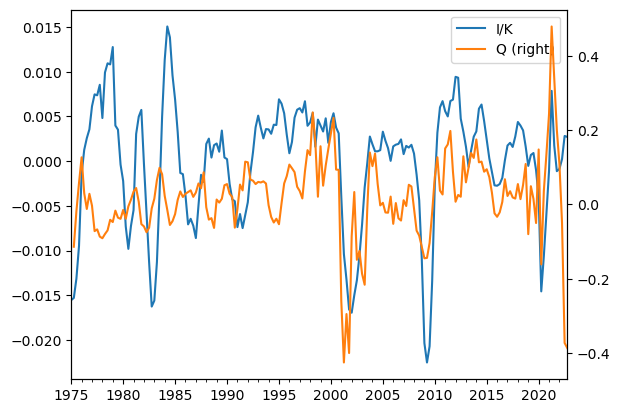

In [10]:
ik.diff(4)['1975Q1':].plot(legend=True,label="I/K");
Q.diff(4)['1975Q1':].shift().plot(legend=True,label="Q",secondary_y=True);

Investment and lagged Q as simple differences (not year-over-year):

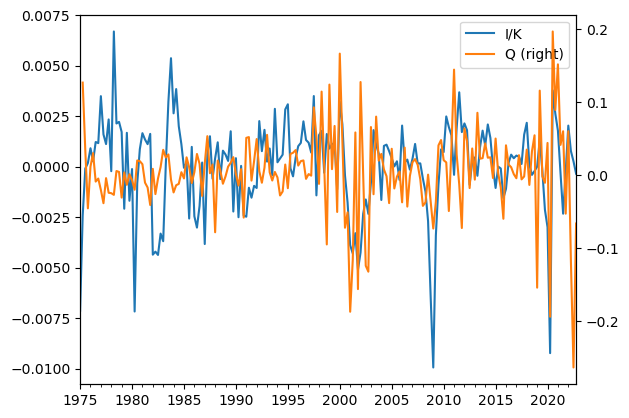

In [11]:
ik.diff()['1975Q1':].plot(legend=True,label="I/K");
Q.diff()['1975Q1':].shift().plot(legend=True,label="Q",secondary_y=True);